### Preprocessing

################################
####     Preprocessing     #####
################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8703 entries, 0 to 8702
Data columns (total 52 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   ID                                                                8703 non-null   int64  
 1   Ref No                                                            8703 non-null   object 
 2    Methods                                                          8703 non-null   object 
 3   Scale                                                             8703 non-null   object 
 4   Crop                                                              8703 non-null   object 
 5   Country                                                           8703 non-null   object 
 6   Site(location)               

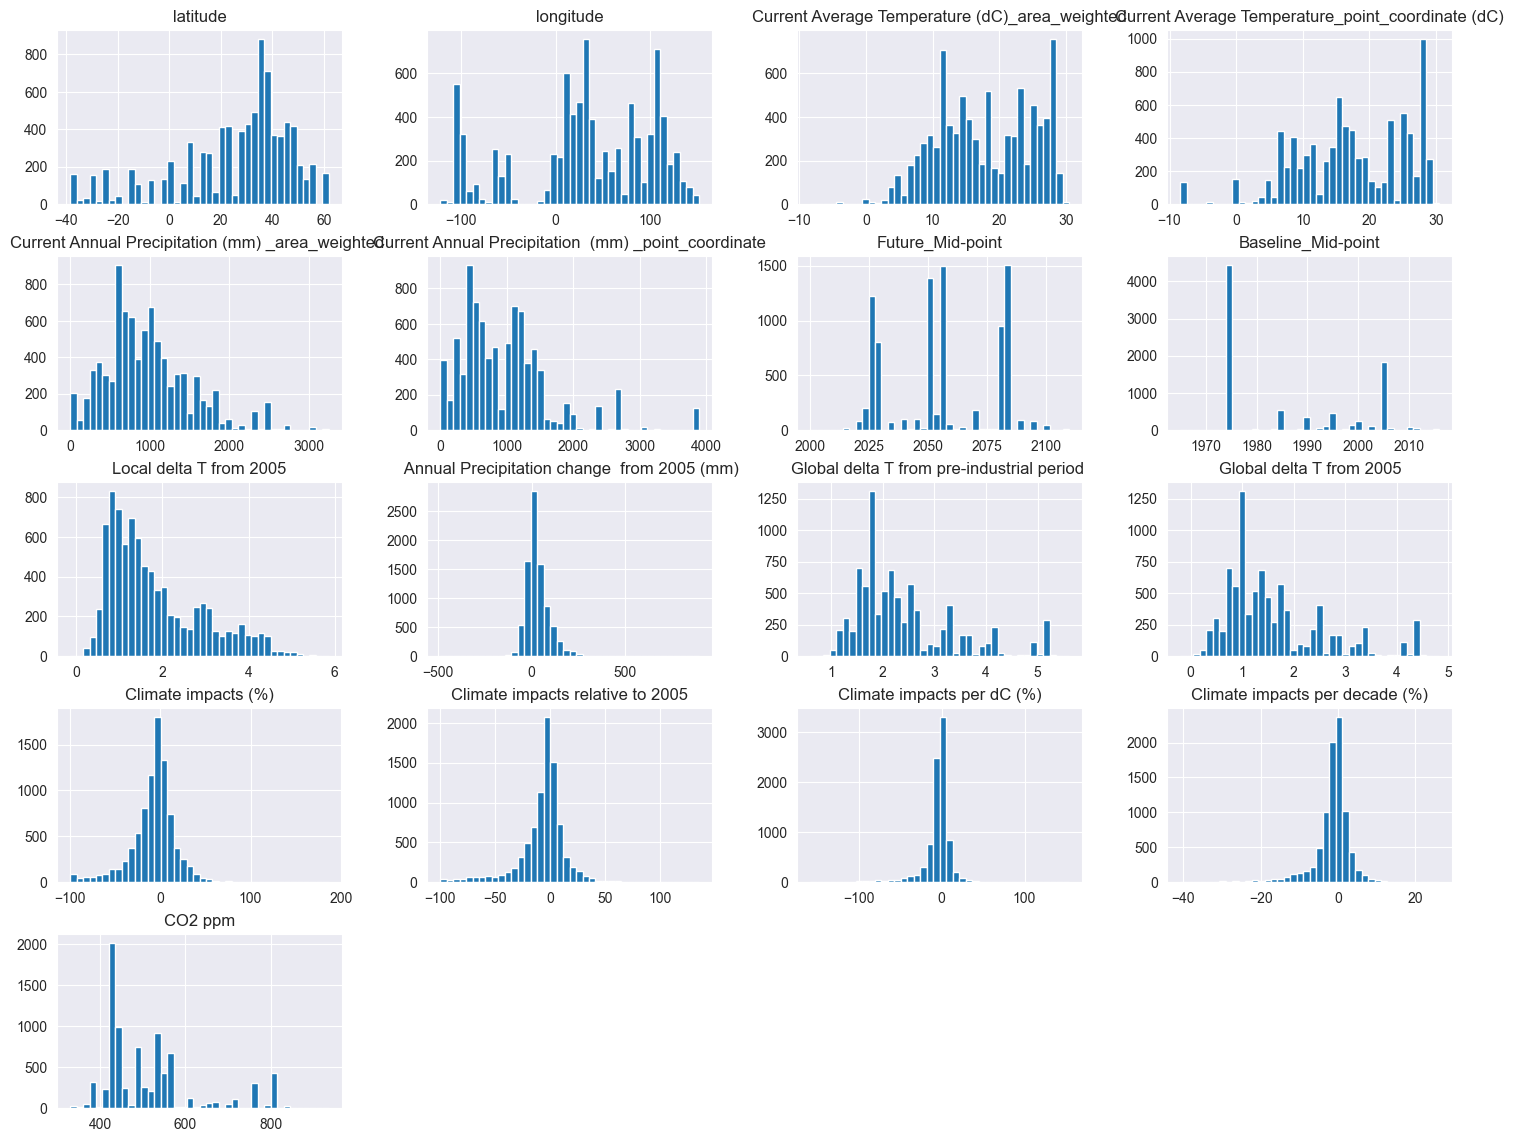

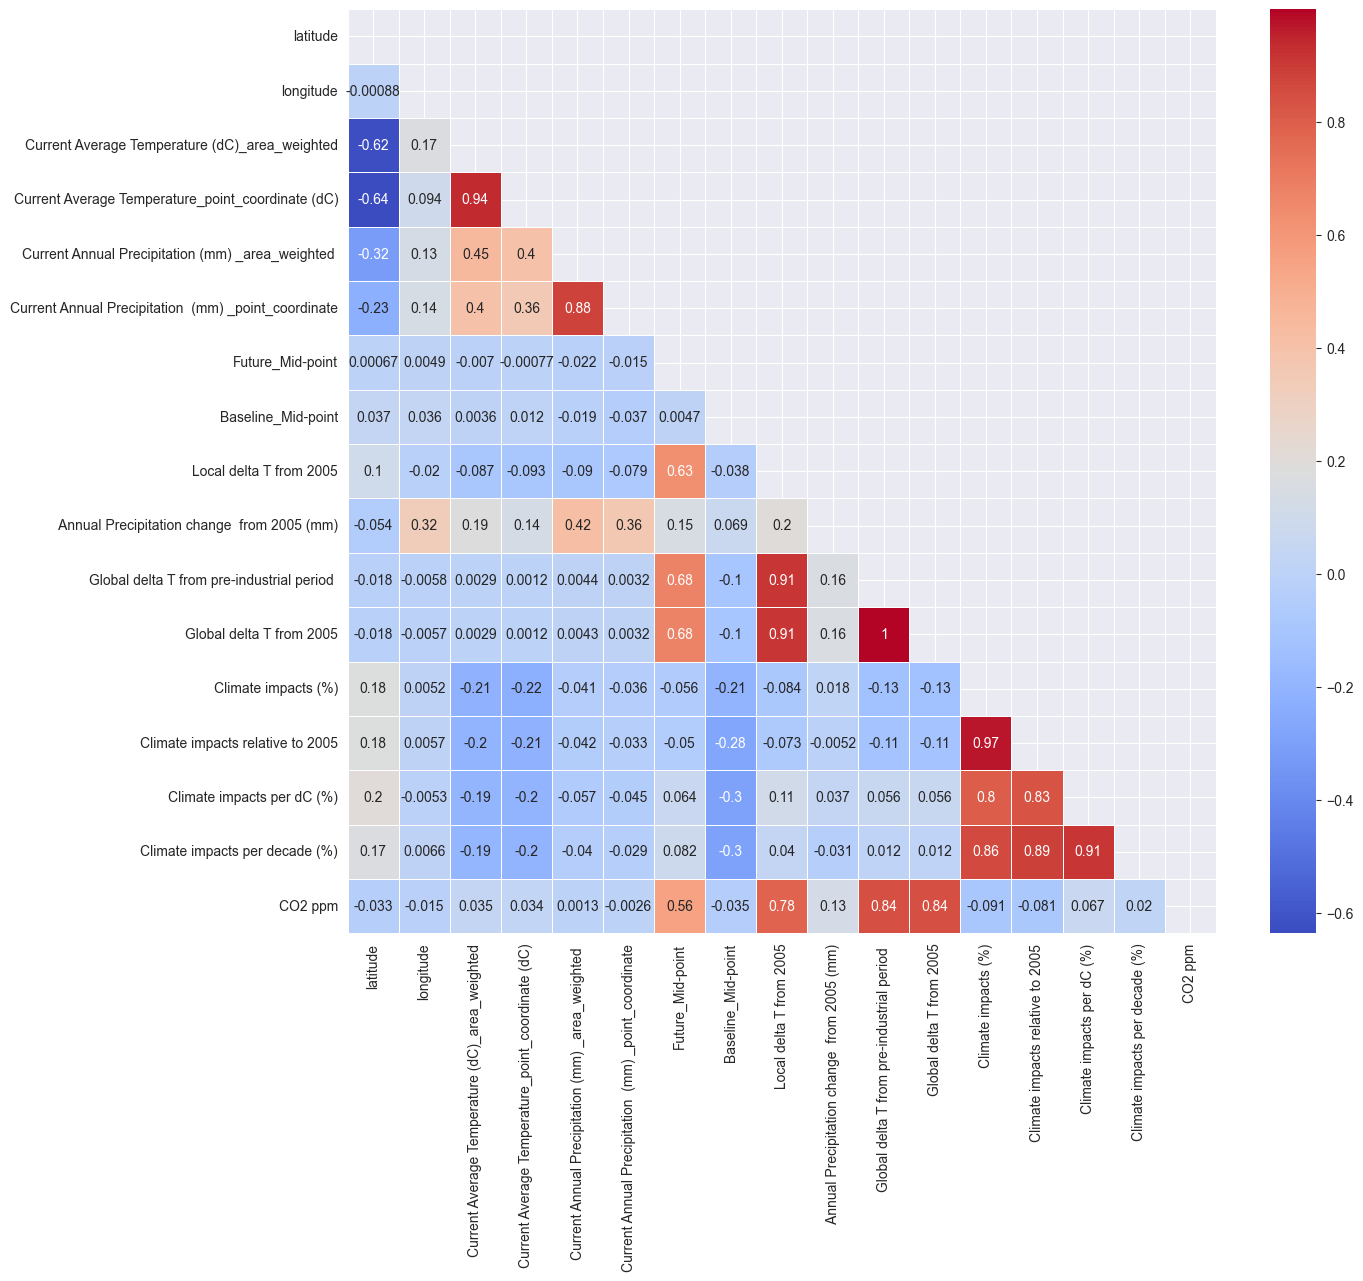

[2054 2055 2050 2025 2035 2045 2070 2090 2028 2053 2078 2085 2089 2030
 2051 2075 2060 2088 2063 2110 2024 2100 2095 2065 2040 2041 2080 2084
 2026 2029 2049 2079 2015 2020 2074 2014 2032 2057 2082 2043 2083 2036
 2031 2023 2033 2034 2094 2052 2000]
2000
2110
float64


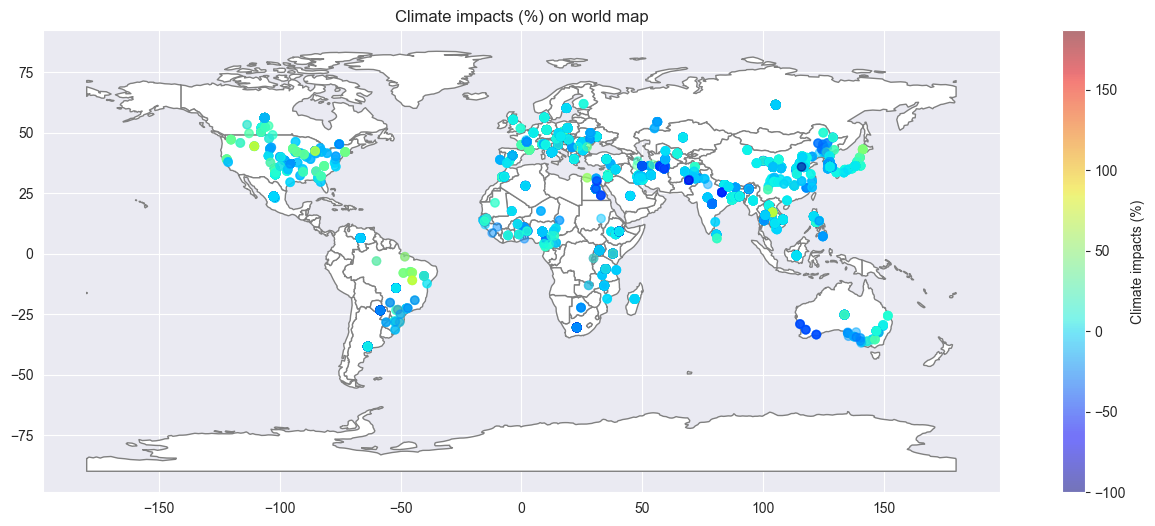

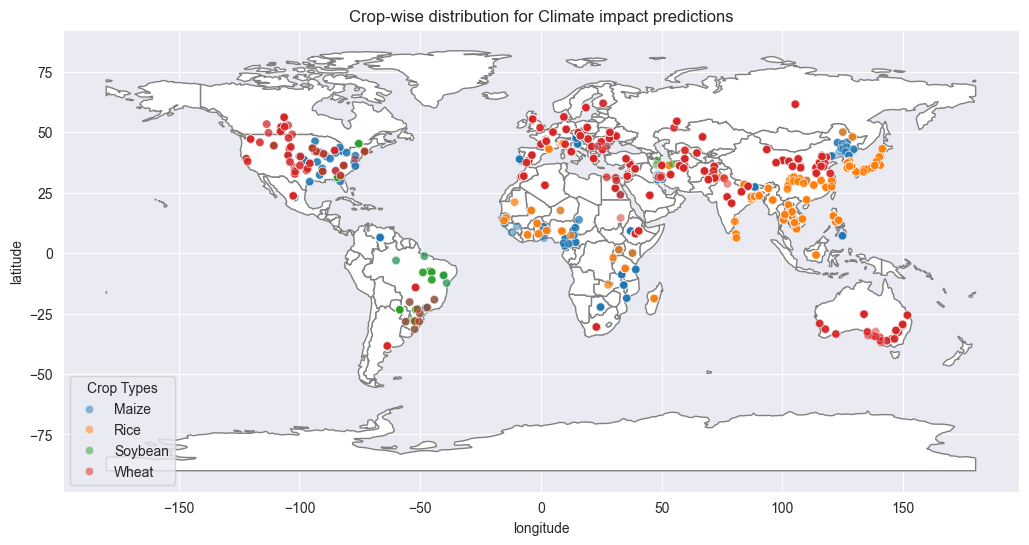

(8703, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8703 entries, 0 to 8702
Data columns (total 30 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Scale                                                 8703 non-null   object 
 1   Crop                                                  8703 non-null   object 
 2   Country                                               8703 non-null   object 
 3   Region                                                8703 non-null   object 
 4   latitude                                              8666 non-null   float64
 5   longitude                                             8666 non-null   float64
 6   Current Average Temperature (dC)_area_weighted        8666 non-null   float64
 7   Current Average Temperature_point_coordinate (dC)     8666 non-null   float64
 8   Current Annual Precipitation (mm) _area_weighte

In [21]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

print("################################")
print("####     Preprocessing     #####")
print("################################")
# Load the data
data = pd.read_excel('Projected_impacts.xlsx', sheet_name='Projected_impacts')
data.head()

data.info()

# Remove the unnecessary columns
truncated_data = data.iloc[:,3:41]
truncated_data.head()

truncated_data.info()

# Removing features with too high (>50%) missing data
new_dataset = truncated_data.drop(columns=['Site(location)','Local delta T ',
                                           'Annual Precipitation change each study  (mm) ',
                                           'Projected yield (t/ha)', 'Scenario source'], inplace=False)
new_dataset.head()

new_dataset.info()

new_dataset.hist(bins=40, figsize=(18,14))
plt.show()

numeric_data = new_dataset.select_dtypes(include=['number'])
corr_matrix = numeric_data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(14,12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask)
plt.show()

x = new_dataset['Future_Mid-point'].unique()
print(x)

print(min(x))
print(max(x))

print(new_dataset['Climate impacts (%)'].dtype)

# Load world map
world = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shx')

# Plot the world map
fig, ax = plt.subplots(figsize=(16,6))
world.plot(ax = ax, color='white', edgecolor='grey')

# Plot your scatter points
scatter = ax.scatter(x=new_dataset['longitude'], y=new_dataset['latitude'],
                     c=new_dataset['Climate impacts (%)'], cmap='jet', alpha=0.5)

# Add a colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Climate impacts (%)')

plt.title('Climate impacts (%) on world map')

plt.show()


# Load world map
world = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shx')

# Plot the world map
fig, ax = plt.subplots(figsize=(16,6))
world.plot(ax = ax, color='white', edgecolor='grey')

# Plot your scatter points
colors = pd.Series(['blue','green','red'])
scatter = sns.scatterplot(
    data = new_dataset, x='longitude',
    y='latitude',
    hue='Crop',
    alpha=0.5,
    ax=ax
)

ax.set_title('Crop-wise distribution for Climate impact predictions')
plt.legend(title='Crop Types', loc='lower left')


plt.show()


new_dataset['Crop'].value_counts()

new_dataset['Adaptation type'].value_counts()

new_dataset['Climate scenario'].value_counts()

new_dataset['Time slice'].value_counts()

print(new_dataset.shape)

# Removing redundant response variables
reduced_dataset = new_dataset.drop(columns=['Climate impacts relative to 2005',
                                            'Climate impacts per dC (%)',
                                            'Climate impacts per decade (%)'],
                                   inplace=False)
reduced_dataset.head()


reduced_dataset['Scale'].value_counts()

reduced_dataset['Tillage'].value_counts()

reduced_dataset.info()

#Imputing missing values
global_data = reduced_dataset.loc[reduced_dataset['Scale'] == 'Global']

columns_to_impute = ['latitude',
                     'longitude',
                     'Current Average Temperature (dC)_area_weighted',
                     'Current Average Temperature_point_coordinate (dC)',
                     'Current Annual Precipitation (mm) _area_weighted ',
                     'Current Annual Precipitation  (mm) _point_coordinate',
                     'Local delta T from 2005',
                     ' Annual Precipitation change  from 2005 (mm)'
                     ]

global_means = global_data[columns_to_impute].mean()
print(global_means)

global_data = reduced_dataset.loc[reduced_dataset['Scale'] == 'Global']

columns_to_impute = ['latitude',
                     'longitude',
                     'Current Average Temperature (dC)_area_weighted',
                     'Current Average Temperature_point_coordinate (dC)',
                     'Current Annual Precipitation (mm) _area_weighted ',
                     'Current Annual Precipitation  (mm) _point_coordinate',
                     'Local delta T from 2005',
                     ' Annual Precipitation change  from 2005 (mm)'
                     ]

global_means = global_data[columns_to_impute].mean()

for col in columns_to_impute:
    reduced_dataset.loc[(reduced_dataset[col].isna()), col] = global_means[col]

for col in columns_to_impute:
    reduced_dataset.loc[(reduced_dataset[col].isna()), col] = global_means[col]

reduced_dataset.info()

X = reduced_dataset.drop('Climate impacts (%)', axis=1)
Y = reduced_dataset['Climate impacts (%)']

# Splitting data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=42,
                                                    test_size=0.2)


# Splitting training data further into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2,
                                                  random_state=43)

print(X_test.shape)

#Preprocessing pipeline
# Separate the numeric and categorical features
categorical_features = x_train.select_dtypes(include=[np.object_]).columns.values
numeric_features = x_train.select_dtypes(include=[np.number]).columns.values

# Separate the numeric and categorical data
numeric_data = x_train.select_dtypes(include=[np.number])
categorical_data = x_train.select_dtypes(include=[np.object_])

# Define numeric preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=5))
])

# Define categorical preprocessing steps
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessors in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply the transformation
x_train_transformed = preprocessor.fit_transform(x_train)
x_train_transformed = x_train_transformed.toarray()

# Transform the validation and test sets
x_val_transformed = preprocessor.transform(x_val)
X_test_transformed = preprocessor.transform(X_test)

# Convert to a dataframe for easy readability
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
transformed_columns = list(numeric_features) + list(encoded_feature_names)
transformed_df = pd.DataFrame(x_train_transformed, columns=transformed_columns)
print(transformed_df)

print(preprocessor)

### Regression

In [22]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicRegressor
from scipy.sparse import issparse
import statsmodels.api as sm
from sklearn.impute import SimpleImputer

print("################################")
print("####       Regression       ####")
print("################################")

# Linear Regression Model
print("Linear Regression Model:\n")
lin_reg = LinearRegression()
lin_reg.fit(x_train_transformed, y_train)

y_pred_train_lr = lin_reg.predict(x_train_transformed)
y_pred_val_lr = lin_reg.predict(x_val_transformed)

mse_train_lr = mean_squared_error(y_train, y_pred_train_lr)
r2_train_lr = r2_score(y_train, y_pred_train_lr)
mse_val_lr = mean_squared_error(y_val, y_pred_val_lr)
r2_val_lr = r2_score(y_val, y_pred_val_lr)

print(f"Linear Regression In-sample MSE: {mse_train_lr:.3f}, R²: {r2_train_lr:.3f}")
print(f"Linear Regression Validation MSE: {mse_val_lr:.3f}, R²: {r2_val_lr:.3f}")

# Ridge Regression
print("Ridge Regression Model:\n")
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(x_train_transformed, y_train)

y_pred_train_ridge = ridge_reg.predict(x_train_transformed)
y_pred_val_ridge = ridge_reg.predict(x_val_transformed)

mse_train_ridge = mean_squared_error(y_train, y_pred_train_ridge)
r2_train_ridge = r2_score(y_train, y_pred_train_ridge)
mse_val_ridge = mean_squared_error(y_val, y_pred_val_ridge)
r2_val_ridge = r2_score(y_val, y_pred_val_ridge)

print(f"Ridge Regression In-sample MSE: {mse_train_ridge:.3f}, R²: {r2_train_ridge:.3f}")
print(f"Ridge Regression Validation MSE: {mse_val_ridge:.3f}, R²: {r2_val_ridge:.3f}")

#Lasso Regression
print("Lasso Regression Model:\n")
lasso_reg = Lasso(alpha=0.01)
lasso_reg.fit(x_train_transformed, y_train)

y_pred_train_lasso = lasso_reg.predict(x_train_transformed)
y_pred_val_lasso = lasso_reg.predict(x_val_transformed)

mse_train_lasso = mean_squared_error(y_train, y_pred_train_lasso)
r2_train_lasso = r2_score(y_train, y_pred_train_lasso)
mse_val_lasso = mean_squared_error(y_val, y_pred_val_lasso)
r2_val_lasso = r2_score(y_val, y_pred_val_lasso)

print(f"Lasso Regression In-sample MSE: {mse_train_lasso:.3f}, R²: {r2_train_lasso:.3f}")
print(f"Lasso Regression Validation MSE: {mse_val_lasso:.3f}, R²: {r2_val_lasso:.3f}")

# Transformed Regression (Polynomial Regression)
print("Polynomial Regression (Degree 2):\n")
poly = PolynomialFeatures(degree=2, include_bias=False)
x_train_poly = poly.fit_transform(x_train_transformed)
x_val_poly = poly.transform(x_val_transformed)

poly_reg = LinearRegression()
poly_reg.fit(x_train_poly, y_train)

y_pred_train_poly = poly_reg.predict(x_train_poly)
y_pred_val_poly = poly_reg.predict(x_val_poly)

mse_train_poly = mean_squared_error(y_train, y_pred_train_poly)
r2_train_poly = r2_score(y_train, y_pred_train_poly)
mse_val_poly = mean_squared_error(y_val, y_pred_val_poly)
r2_val_poly = r2_score(y_val, y_pred_val_poly)

print(f"Polynomial Regression In-sample MSE: {mse_train_poly:.3f}, R²: {r2_train_poly:.3f}")
print(f"Polynomial Regression Validation MSE: {mse_val_poly:.3f}, R²: {r2_val_poly:.3f}")

# Symbolic Regression
print("\n\nSymbolic Regression Model:\n")
# Check if the data is sparse and convert if necessary
if issparse(x_train_transformed):
    x_train_dense = x_train_transformed.toarray()
else:
    x_train_dense = x_train_transformed

if issparse(x_val_transformed):
    x_val_dense = x_val_transformed.toarray()
else:
    x_val_dense = x_val_transformed

sym_reg = SymbolicRegressor(
    population_size=2000,
    generations=20,
    stopping_criteria=0.01,
    p_crossover=0.7,
    p_subtree_mutation=0.1,
    p_hoist_mutation=0.05,
    p_point_mutation=0.1,
    max_samples=0.9,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
sym_reg.fit(x_train_dense, y_train)

y_pred_train_sym = sym_reg.predict(x_train_dense)
y_pred_val_sym = sym_reg.predict(x_val_dense)

mse_train_sym = mean_squared_error(y_train, y_pred_train_sym)
r2_train_sym = r2_score(y_train, y_pred_train_sym)
mse_val_sym = mean_squared_error(y_val, y_pred_val_sym)
r2_val_sym = r2_score(y_val, y_pred_val_sym)

print(f"Symbolic Regression In-sample MSE: {mse_train_sym:.3f}, R²: {r2_train_sym:.3f}")
print(f"Symbolic Regression Validation MSE: {mse_val_sym:.3f}, R²: {r2_val_sym:.3f}")

# 5x Cross-Validation
print("5-Fold Cross-Validation:\n")
cv_scores_lr = cross_val_score(lin_reg, X_test_transformed, Y_test, scoring='r2', cv=5)
cv_scores_ridge = cross_val_score(ridge_reg, X_test_transformed, Y_test, scoring='r2', cv=5)
cv_scores_lasso = cross_val_score(lasso_reg, X_test_transformed, Y_test, scoring='r2', cv=5)

print(f"Linear Regression Mean R² CV Score: {cv_scores_lr.mean():.3f}")
print(f"Ridge Regression Mean R² CV Score: {cv_scores_ridge.mean():.3f}")
print(f"Lasso Regression Mean R² CV Score: {cv_scores_lasso.mean():.3f}")

# Combined R² Scores Summary Plot
plt.figure(figsize=(10, 6))
r2_scores = [r2_val_lr, r2_val_ridge, r2_val_lasso, r2_val_poly, r2_val_sym]
models = ['Linear', 'Ridge', 'Lasso', 'Polynomial', 'Symbolic']
plt.bar(models, r2_scores, color='skyblue', alpha=0.8)
plt.ylabel("R² Score")
plt.title("Validation R² Score Comparison Across Models")
plt.ylim(0, 1)
plt.show()

# Individual Model Plots
def plot_predicted_vs_actual(y_actual, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_actual, y_pred, alpha=0.6, label="Predicted vs Actual")
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'k--', lw=2, label="Perfect Prediction")
    plt.title(title)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.show()

plot_predicted_vs_actual(y_val, y_pred_val_lr, "Linear Regression: Predicted vs Actual")
plot_predicted_vs_actual(y_val, y_pred_val_ridge, "Ridge Regression: Predicted vs Actual")
plot_predicted_vs_actual(y_val, y_pred_val_lasso, "Lasso Regression: Predicted vs Actual")
plot_predicted_vs_actual(y_val, y_pred_val_poly, "Polynomial Regression: Predicted vs Actual")
plot_predicted_vs_actual(y_val, y_pred_val_sym, "Symbolic Regression: Predicted vs Actual")

#Feature Selection
X = reduced_dataset.drop('Climate impacts (%)', axis=1)
y = reduced_dataset['Climate impacts (%)'].astype(float)  # Ensure 'y' is float
X = pd.get_dummies(X, drop_first=True)
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Define the forward selection function
def forward_selection(X, y, significance_level=0.05):
    initial_features = X.columns.tolist()
    selected_features = []
    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(selected_features))
        new_pval = pd.Series(index=remaining_features)
        for feature in remaining_features:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[selected_features + [feature]]))).fit()
            new_pval[feature] = model.pvalues[feature]
        min_p_value = new_pval.min()
        if min_p_value < significance_level:
            selected_features.append(new_pval.idxmin())
        else:
            break
    return selected_features

# Define the backward elimination function
def backward_elimination(X, y, significance_level=0.05):
    features = X.columns.tolist()
    while len(features) > 0:
        X_with_const = sm.add_constant(X[features])
        model = sm.OLS(y, X_with_const).fit()
        p_values = model.pvalues.iloc[1:]  # exclude the intercept
        max_p_value = p_values.max()
        if max_p_value > significance_level:
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break
    return features

# Define the stepwise selection function
def stepwise_selection(X, y, significance_level_in=0.05, significance_level_out=0.05):
    initial_features = X.columns.tolist()
    selected_features = []
    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(selected_features))
        new_pval = pd.Series(index=remaining_features)
        for feature in remaining_features:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[selected_features + [feature]]))).fit()
            new_pval[feature] = model.pvalues[feature]
        min_p_value = new_pval.min()
        if min_p_value < significance_level_in:
            selected_features.append(new_pval.idxmin())
            while True:
                model = sm.OLS(y, sm.add_constant(X[selected_features])).fit()
                p_values = model.pvalues.iloc[1:]  # exclude the intercept
                max_p_value = p_values.max()
                if max_p_value > significance_level_out:
                    excluded_feature = p_values.idxmax()
                    selected_features.remove(excluded_feature)
                else:
                    break
        else:
            break
    return selected_features

selected_features_forward = forward_selection(X, y)
print("Selected features via Forward Selection:", selected_features_forward)

selected_features_backward = backward_elimination(X, y)
print("Selected features via Backward Elimination:", selected_features_backward)

selected_features_stepwise = stepwise_selection(X, y)
print("Selected features via Stepwise Selection:", selected_features_stepwise)


################################
####       Regression       ####
################################
Linear Regression Model:

Linear Regression In-sample MSE: 437.931, R²: 0.294
Linear Regression Validation MSE: 102128599133455300689920.000, R²: -167293597802478174208.000
Ridge Regression Model:

Ridge Regression In-sample MSE: 381.752, R²: 0.385
Ridge Regression Validation MSE: 397.652, R²: 0.349
Lasso Regression Model:

Lasso Regression In-sample MSE: 386.176, R²: 0.378
Lasso Regression Validation MSE: 399.291, R²: 0.346
Polynomial Regression (Degree 2):



KeyboardInterrupt: 

### Neural Networks

In [8]:
import optuna
import numpy as np
import pandas as pd
import random
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    MaxPooling2D,
    Concatenate
)
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

print("################################")
print("####     NeuralNetworks     ####")
print("################################")

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Placeholder for results
results = {}

#Models
def model_1l(params):
    model = Sequential([
        Input(shape=(x_train_transformed.shape[1],)),
        Dense(params['neurons'], activation=params['activation']),
        Dense(1, activation='linear')
    ])
    return model

def model_3l(params):
    model = Sequential([
        Input(shape=(x_train_transformed.shape[1],)),
        Dense(params['neurons'], activation=params['activation']),
        Dropout(params['dropout_rate']),
        Dense(params['neurons'], activation=params['activation']),
        Dropout(params['dropout_rate']),
        Dense(params['neurons'], activation=params['activation']),
        Dense(1, activation='linear')
    ])
    return model

def model_4l(params):
    model = Sequential([
        Input(shape=(x_train_transformed.shape[1],)),
        Dense(params['neurons'], activation=params['activation']),
        Dropout(params['dropout_rate']),
        Dense(params['neurons'], activation=params['activation']),
        Dropout(params['dropout_rate']),
        Dense(params['neurons'], activation=params['activation']),
        Dense(params['neurons'], activation=params['activation']),
        Dense(1, activation='linear')
    ])
    return model

def model_progressive(params):
    model = Sequential([
        Input(shape=(x_train_transformed.shape[1],)),
        Dense(params['neurons'] * 1, activation=params['activation']),
        Dropout(params['dropout_rate']),
        Dense(params['neurons'] * 2, activation=params['activation']),
        Dropout(params['dropout_rate']),
        Dense(params['neurons'] * 3, activation=params['activation']),
        Dropout(params['dropout_rate']),
        Dense(params['neurons'] * 4, activation=params['activation']),
        Dense(1, activation='linear')
    ])
    return model

def model_widedeep(params):
    deep_input = Input(shape=(x_train_transformed.shape[1],), name='deep')
    wide_input = Input(shape=(x_train_transformed.shape[1],), name='wide')

    # Deep component
    deep = deep_input
    for _ in range(3):
        deep = Dense(params['neurons'], activation=params['activation'])(deep)
        deep = Dropout(params['dropout_rate'])(deep)

    # Combine wide and deep
    combined = Concatenate()([wide_input, deep])
    output = Dense(1, activation='linear')(combined)
    model = Model(inputs=[wide_input, deep_input], outputs=output)
    return model

def model_cnn(params):
    # Convert data to dense format if sparse
    input_shape = (x_train_transformed.shape[1], 1, 1)
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(filters=params['filters'], kernel_size=(3, 1), activation=params['activation']),
        MaxPooling2D(pool_size=(2, 1)),
        Dropout(params['dropout_rate']),
        Flatten(),
        Dense(params['neurons'], activation=params['activation']),
        Dense(1, activation='linear')  # Regression output
    ])
    return model

models_to_test = {
    "1L": model_1l,
    "3L": model_3l,
    "4L": model_4l,
    "Progressive": model_progressive,
    "WideDeep": model_widedeep,
    "CNN": model_cnn
}

#Run Models
# Function to train and evaluate a model
def build_and_evaluate_nn(label, model_fn, params):
    print(f"Training {label}...")

    # Prepare input data based on model type
    if label == "WideDeep":
        inputs_train = {"wide": x_train_transformed, "deep": x_train_transformed}
        inputs_val = {"wide": x_val_transformed, "deep": x_val_transformed}
        inputs_test = {"wide": X_test_transformed, "deep": X_test_transformed}
    elif label == "CNN":
        # Convert sparse to dense and reshape for CNN
        x_train_dense = x_train_transformed.toarray() if hasattr(x_train_transformed, "toarray") else x_train_transformed
        x_val_dense = x_val_transformed.toarray() if hasattr(x_val_transformed, "toarray") else x_val_transformed
        x_test_dense = X_test_transformed.toarray() if hasattr(X_test_transformed, "toarray") else X_test_transformed

        inputs_train = x_train_dense.reshape(-1, x_train_dense.shape[1], 1, 1)
        inputs_val = x_val_dense.reshape(-1, x_val_dense.shape[1], 1, 1)
        inputs_test = x_test_dense.reshape(-1, x_test_dense.shape[1], 1, 1)
    else:
        inputs_train = x_train_transformed
        inputs_val = x_val_transformed
        inputs_test = X_test_transformed

    # Build and compile the model
    model = model_fn(params)
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mse', metrics=['mse'])

    # Early stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(
        inputs_train,
        y_train,
        validation_data=(inputs_val, y_val),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        callbacks=[early_stop],
        verbose=0
    )

    # Evaluate the model on the test set
    test_loss, test_mse = model.evaluate(inputs_test, Y_test, verbose=0)
    y_pred = model.predict(inputs_test, verbose=0)
    mse_test = mean_squared_error(Y_test, y_pred)
    r2_test = r2_score(Y_test, y_pred)

    # Calculate validation R²
    val_predictions = model.predict(inputs_val, verbose=0)
    val_r2 = r2_score(y_val, val_predictions)

    # Store results
    results[label] = {
        "Test MSE": mse_test,
        "Test R²": r2_test,
        "Validation R²": val_r2
    }

    print(f"{label} - Test MSE: {mse_test:.3f}, Test R²: {r2_test:.3f}, Validation R²: {val_r2:.3f}")

# Define hyperparameters for each model
hyperparameters = {
    "1L": {"neurons": 64, "activation": "relu", "dropout_rate": 0.1, "learning_rate": 0.001, "batch_size": 32, "epochs": 50},
    "3L": {"neurons": 128, "activation": "relu", "dropout_rate": 0.2, "learning_rate": 0.001, "batch_size": 32, "epochs": 50},
    "4L": {"neurons": 128, "activation": "relu", "dropout_rate": 0.2, "learning_rate": 0.001, "batch_size": 32, "epochs": 50},
    "Progressive": {"neurons": 64, "activation": "relu", "dropout_rate": 0.2, "learning_rate": 0.001, "batch_size": 32, "epochs": 50},
    "WideDeep": {"neurons": 64, "activation": "relu", "dropout_rate": 0.2, "learning_rate": 0.001, "batch_size": 32, "epochs": 50},
    "CNN": {"filters": 32, "neurons": 64, "activation": "relu", "dropout_rate": 0.2, "learning_rate": 0.001, "batch_size": 32, "epochs": 50}
}

# Train and evaluate each model
for label, model_fn in models_to_test.items():
    build_and_evaluate_nn(label, model_fn, hyperparameters[label])

# Display results in a table
results_df = pd.DataFrame(results).T.reset_index()
results_df.columns = ["Model", "Test MSE", "Test R²", "Validation R²"]
results_df = results_df.sort_values(by="Test MSE")
print("\nResults Summary:")
print(results_df)

#Cross Eval
def cross_validate_nn(label, model_fn, params, x_data, y_data, k=5):
    print(f"Cross-validating {label} with up to {k}-folds...")

    n_samples = x_data.shape[0]
    n_splits = min(k, n_samples)
    if n_splits < 2:
        raise ValueError(f"Not enough samples for cross-validation. Found {n_samples}, need at least 2.")

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    fold_results = []
    y_data_np = y_data.to_numpy()

    for fold, (train_idx, val_idx) in enumerate(kfold.split(x_data), 1):
        print(f"  Fold {fold}/{n_splits}...")

        if label == "WideDeep":
            x_data_wide = {"wide": x_data, "deep": x_data}
            x_train_fold = {"wide": x_data_wide["wide"][train_idx], "deep": x_data_wide["deep"][train_idx]}
            x_val_fold = {"wide": x_data_wide["wide"][val_idx], "deep": x_data_wide["deep"][val_idx]}
        elif label == "CNN":
            x_dense = x_data.toarray() if hasattr(x_data, "toarray") else x_data
            x_train_fold = x_dense[train_idx].reshape(-1, x_dense.shape[1], 1, 1)
            x_val_fold = x_dense[val_idx].reshape(-1, x_dense.shape[1], 1, 1)
        else:
            x_train_fold, x_val_fold = x_data[train_idx], x_data[val_idx]

        y_train_fold, y_val_fold = y_data_np[train_idx], y_data_np[val_idx]

        model = model_fn(params)
        model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mse', metrics=['mse'])

        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model.fit(
            x_train_fold,
            y_train_fold,
            validation_data=(x_val_fold, y_val_fold),
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            callbacks=[early_stop],
            verbose=0
        )

        y_pred_fold = model.predict(x_val_fold, verbose=0)
        mse_fold = mean_squared_error(y_val_fold, y_pred_fold)
        r2_fold = r2_score(y_val_fold, y_pred_fold)

        fold_results.append({"MSE": mse_fold, "R²": r2_fold})
        print(f"    Fold {fold} - MSE: {mse_fold:.3f}, R²: {r2_fold:.3f}")

    avg_mse = np.mean([result["MSE"] for result in fold_results])
    avg_r2 = np.mean([result["R²"] for result in fold_results])
    print(f"{label} - Average MSE: {avg_mse:.3f}, Average R²: {avg_r2:.3f}\n")

    return {"Model": label, "Average MSE": avg_mse, "Average R²": avg_r2}

# Perform cross-validation dynamically for each model
cv_results = []
for label, model_fn in models_to_test.items():
    cv_results.append(cross_validate_nn(label, model_fn, hyperparameters[label], x_train_transformed, y_train))

# Display results
cv_results_df = pd.DataFrame(cv_results).sort_values(by="Average MSE")
print("\nCross-Validation Results:")
print(cv_results_df)

## Finding Best Prarameters using Optuna (DO NOT RUN)
# Objective function for Optuna
def objective(trial, model_fn, label):
    # Suggest hyperparameters
    params = {
        "neurons": trial.suggest_categorical("neurons", [64, 128, 256]),
        "activation": trial.suggest_categorical("activation", ["relu", "tanh"]),
        "dropout_rate": trial.suggest_float("dropout_rate", 0.0, 0.4, step=0.1),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64]),
        "epochs": trial.suggest_int("epochs", 20, 50),
    }
    if label == "CNN":
        params["filters"] = trial.suggest_categorical("filters", [32, 64, 128])

    # Prepare input data based on model type
    if label == "WideDeep":
        inputs_train = {"wide": x_train_transformed, "deep": x_train_transformed}
        inputs_val = {"wide": x_val_transformed, "deep": x_val_transformed}
    elif label == "CNN":
        x_train_dense = x_train_transformed.toarray() if hasattr(x_train_transformed, "toarray") else x_train_transformed
        x_val_dense = x_val_transformed.toarray() if hasattr(x_val_transformed, "toarray") else x_val_transformed
        inputs_train = x_train_dense.reshape(-1, x_train_dense.shape[1], 1, 1)
        inputs_val = x_val_dense.reshape(-1, x_val_dense.shape[1], 1, 1)
    else:
        inputs_train = x_train_transformed
        inputs_val = x_val_transformed

    # Build and compile the model
    model = model_fn(params)
    model.compile(optimizer=Adam(learning_rate=params["learning_rate"]), loss="mse", metrics=["mse"])

    # Early stopping
    early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(
        inputs_train,
        y_train,
        validation_data=(inputs_val, y_val),
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        callbacks=[early_stop],
        verbose=0
    )

    # Evaluate on validation data and extract the loss
    val_loss = model.evaluate(inputs_val, y_val, verbose=0)[0]  # Extract only the loss value
    return val_loss

# Run Optuna optimization for each model
studies = {}
for label, model_fn in models_to_test.items():
    print(f"Optimizing {label}...")
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, model_fn, label), n_trials=50)
    studies[label] = study
    print(f"Best parameters for {label}: {study.best_params}")

# Display best parameters for all models
for label, study in studies.items():
    print(f"\n{label} Best Parameters: {study.best_params}")

optimized_hyperparameters = {
    "1L": {'neurons': 256, 'activation': 'tanh', 'dropout_rate': 0.1, 'learning_rate': 0.003672337909839522, 'batch_size': 32, 'epochs': 50},
    "3L": {'neurons': 256, 'activation': 'relu', 'dropout_rate': 0.2, 'learning_rate': 0.004737625395147377, 'batch_size': 32, 'epochs': 33},
    "4L": {'neurons': 256, 'activation': 'relu', 'dropout_rate': 0.2, 'learning_rate': 0.00048821178688752856, 'batch_size': 64, 'epochs': 43},
    "Progressive": {'neurons': 256, 'activation': 'relu', 'dropout_rate': 0.3, 'learning_rate': 0.0006913468844528289, 'batch_size': 32, 'epochs': 47},
    "WideDeep": {'neurons': 128, 'activation': 'tanh', 'dropout_rate': 0.1, 'learning_rate': 0.006691701842195688, 'batch_size': 64, 'epochs': 48},
    "CNN": {'filters': 64, 'neurons': 256, 'activation': 'relu', 'dropout_rate': 0.4, 'learning_rate': 0.0064339909388157635, 'batch_size': 64, 'epochs': 42}
}

## Models with opitmized parameters using Optuna
# Function to train and evaluate models with optimized parameters
def build_and_evaluate_optimized_nn(label, model_fn, params):
    print(f"Training {label} with optimized hyperparameters...")

    # Prepare input data based on model type
    if label == "WideDeep":
        inputs_train = {"wide": x_train_transformed, "deep": x_train_transformed}
        inputs_val = {"wide": x_val_transformed, "deep": x_val_transformed}
        inputs_test = {"wide": X_test_transformed, "deep": X_test_transformed}
    elif label == "CNN":
        x_train_dense = x_train_transformed.toarray() if hasattr(x_train_transformed, "toarray") else x_train_transformed
        x_val_dense = x_val_transformed.toarray() if hasattr(x_val_transformed, "toarray") else x_val_transformed
        x_test_dense = X_test_transformed.toarray() if hasattr(X_test_transformed, "toarray") else X_test_transformed

        inputs_train = x_train_dense.reshape(-1, x_train_dense.shape[1], 1, 1)
        inputs_val = x_val_dense.reshape(-1, x_val_dense.shape[1], 1, 1)
        inputs_test = x_test_dense.reshape(-1, x_test_dense.shape[1], 1, 1)
    else:
        inputs_train = x_train_transformed
        inputs_val = x_val_transformed
        inputs_test = X_test_transformed

    # Build and compile the model
    model = model_fn(params)
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mse', metrics=['mse'])

    # Early stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(
        inputs_train,
        y_train,
        validation_data=(inputs_val, y_val),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        callbacks=[early_stop],
        verbose=0
    )

    # Evaluate the model on the test set
    test_loss, test_mse = model.evaluate(inputs_test, Y_test, verbose=0)
    y_pred = model.predict(inputs_test, verbose=0)
    mse_test = mean_squared_error(Y_test, y_pred)
    r2_test = r2_score(Y_test, y_pred)

    # Calculate validation R²
    val_predictions = model.predict(inputs_val, verbose=0)
    val_r2 = r2_score(y_val, val_predictions)

    # Store results
    results[label] = {
        "Test MSE": mse_test,
        "Test R²": r2_test,
        "Validation R²": val_r2
    }

    print(f"{label} - Test MSE: {mse_test:.3f}, Test R²: {r2_test:.3f}, Validation R²: {val_r2:.3f}")

# Train and evaluate each model with optimized parameters
results = {}
for label, model_fn in models_to_test.items():
    build_and_evaluate_optimized_nn(label, model_fn, optimized_hyperparameters[label])

# Display results in a table
optimized_results_df = pd.DataFrame(results).T.reset_index()
optimized_results_df.columns = ["Model", "Test MSE", "Test R²", "Validation R²"]
optimized_results_df = optimized_results_df.sort_values(by="Test MSE")
print("\nOptimized Results Summary:")
print(optimized_results_df)

## Cross Eval for Optimized Models
# Function for cross-validation using optimized hyperparameters
def cross_validate_optimized_nn(label, model_fn, params, x_data, y_data, k=5):
    print(f"Cross-validating {label} with up to {k}-folds using optimized hyperparameters...")

    n_samples = x_data.shape[0]
    n_splits = min(k, n_samples)
    if n_splits < 2:
        raise ValueError(f"Not enough samples for cross-validation. Found {n_samples}, need at least 2.")

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    fold_results = []
    y_data_np = y_data.to_numpy()

    for fold, (train_idx, val_idx) in enumerate(kfold.split(x_data), 1):
        print(f"  Fold {fold}/{n_splits}...")

        if label == "WideDeep":
            x_data_wide = {"wide": x_data, "deep": x_data}
            x_train_fold = {"wide": x_data_wide["wide"][train_idx], "deep": x_data_wide["deep"][train_idx]}
            x_val_fold = {"wide": x_data_wide["wide"][val_idx], "deep": x_data_wide["deep"][val_idx]}
        elif label == "CNN":
            x_dense = x_data.toarray() if hasattr(x_data, "toarray") else x_data
            x_train_fold = x_dense[train_idx].reshape(-1, x_dense.shape[1], 1, 1)
            x_val_fold = x_dense[val_idx].reshape(-1, x_dense.shape[1], 1, 1)
        else:
            x_train_fold, x_val_fold = x_data[train_idx], x_data[val_idx]

        y_train_fold, y_val_fold = y_data_np[train_idx], y_data_np[val_idx]

        # Build and compile the model
        model = model_fn(params)
        model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mse', metrics=['mse'])

        # Early stopping
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model.fit(
            x_train_fold,
            y_train_fold,
            validation_data=(x_val_fold, y_val_fold),
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            callbacks=[early_stop],
            verbose=0
        )

        # Evaluate on validation set
        y_pred_fold = model.predict(x_val_fold, verbose=0)
        mse_fold = mean_squared_error(y_val_fold, y_pred_fold)
        r2_fold = r2_score(y_val_fold, y_pred_fold)

        fold_results.append({"MSE": mse_fold, "R²": r2_fold})
        print(f"    Fold {fold} - MSE: {mse_fold:.3f}, R²: {r2_fold:.3f}")

    # Aggregate results
    avg_mse = np.mean([result["MSE"] for result in fold_results])
    avg_r2 = np.mean([result["R²"] for result in fold_results])
    print(f"{label} - Average MSE: {avg_mse:.3f}, Average R²: {avg_r2:.3f}\n")

    return {"Model": label, "Average MSE": avg_mse, "Average R²": avg_r2}

# Perform cross-validation for each optimized model
optimized_cv_results = []
for label, model_fn in models_to_test.items():
    optimized_cv_results.append(
        cross_validate_optimized_nn(label, model_fn, optimized_hyperparameters[label], x_train_transformed, y_train)
    )

# Display results
optimized_cv_results_df = pd.DataFrame(optimized_cv_results).sort_values(by="Average MSE")
print("\nOptimized Cross-Validation Results:")
print(optimized_cv_results_df)

# Display all results grouped by optimized and non-optimized
def display_grouped_results(initial_results_df, optimized_results_df, cross_validation_results_df, optimized_cross_validation_results_df):
    """
    Display initial and optimized results separately, grouped for better clarity.
    """
    # Rename columns for clarity
    initial_results_df = initial_results_df.rename(
        columns={"Test MSE": "Test MSE", "Test R²": "Test R²", "Validation R²": "Validation R²"}
    ).assign(Group="Non-Optimized")

    optimized_results_df = optimized_results_df.rename(
        columns={"Test MSE": "Test MSE", "Test R²": "Test R²", "Validation R²": "Validation R²"}
    ).assign(Group="Optimized")

    cross_validation_results_df = cross_validation_results_df.rename(
        columns={"Average MSE": "CV MSE", "Average R²": "CV R²"}
    ).assign(Group="Non-Optimized")

    optimized_cross_validation_results_df = optimized_cross_validation_results_df.rename(
        columns={"Average MSE": "CV MSE", "Average R²": "CV R²"}
    ).assign(Group="Optimized")

    # Display Non-Optimized Results
    print("\nNon-Optimized Results:")
    print("=" * 100)
    non_optimized_results = pd.concat(
        [initial_results_df, cross_validation_results_df], axis=1
    ).drop("Group", axis=1)
    print(non_optimized_results.to_string(index=False))

    # Display Optimized Results
    print("\nOptimized Results:")
    print("=" * 100)
    optimized_results = pd.concat(
        [optimized_results_df, optimized_cross_validation_results_df], axis=1
    ).drop("Group", axis=1)
    print(optimized_results.to_string(index=False))

    # Return grouped DataFrames for further use if needed
    return non_optimized_results, optimized_results

# Display grouped results
non_optimized_summary, optimized_summary = display_grouped_results(
    initial_results_df=results_df,  # From initial models
    optimized_results_df=optimized_results_df,  # From optimized models
    cross_validation_results_df=cv_results_df,  # From cross-validation of initial models
    optimized_cross_validation_results_df=optimized_cv_results_df  # From cross-validation of optimized models
)

# Save grouped results to separate files
non_optimized_summary.to_csv("non_optimized_results_summary.csv", index=False)
optimized_summary.to_csv("optimized_results_summary.csv", index=False)

## Graphs
### Real vs Predicted
# Function to create real vs. predicted plots
def plot_real_vs_predicted(label, model_fn, params, x_data, y_data, optimized=False):
    """
    Plot real vs. predicted values for a given model.
    """
    # Prepare data based on model type
    if label == "WideDeep":
        inputs_data = {"wide": x_data, "deep": x_data}
    elif label == "CNN":
        x_dense = x_data.toarray() if hasattr(x_data, "toarray") else x_data
        inputs_data = x_dense.reshape(-1, x_dense.shape[1], 1, 1)
    else:
        inputs_data = x_data

    # Build and compile the model
    model = model_fn(params)
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mse', metrics=['mse'])

    # Train the model on full training data
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(
        inputs_data,
        y_data,
        validation_split=0.2,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        callbacks=[early_stop],
        verbose=0
    )

    # Make predictions
    y_pred = model.predict(inputs_data, verbose=0)

    # Plot Real vs. Predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_data, y_pred, alpha=0.6, label="Predicted vs Real")
    plt.plot([y_data.min(), y_data.max()], [y_data.min(), y_data.max()], 'r--', label="Ideal Fit")
    plt.xlabel("Real Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Real vs Predicted for {'Optimized' if optimized else 'Non-Optimized'} {label}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Create plots for all models
for label, model_fn in models_to_test.items():
    # Non-optimized
    plot_real_vs_predicted(label, model_fn, hyperparameters[label], x_train_transformed, y_train, optimized=False)

    # Optimized
    plot_real_vs_predicted(label, model_fn, optimized_hyperparameters[label], x_train_transformed, y_train, optimized=True)

### Validation loss

# Function to plot validation loss for a model
def plot_validation_loss(label, model_fn, params, x_data, y_data, optimized=False):
    """
    Plot validation loss during training for a given model.
    """
    # Prepare data based on model type
    if label == "WideDeep":
        inputs_data = {"wide": x_data, "deep": x_data}
    elif label == "CNN":
        x_dense = x_data.toarray() if hasattr(x_data, "toarray") else x_data
        inputs_data = x_dense.reshape(-1, x_dense.shape[1], 1, 1)
    else:
        inputs_data = x_data

    # Build and compile the model
    model = model_fn(params)
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mse', metrics=['mse'])

    # Train the model
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        inputs_data,
        y_data,
        validation_split=0.2,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        callbacks=[early_stop],
        verbose=0
    )

    # Plot validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['val_loss'], label="Validation Loss", marker='o')
    plt.plot(history.history['loss'], label="Training Loss", marker='x')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Validation Loss for {'Optimized' if optimized else 'Non-Optimized'} {label}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Create validation loss plots for all models
for label, model_fn in models_to_test.items():
    # Non-optimized
    plot_validation_loss(label, model_fn, hyperparameters[label], x_train_transformed, y_train, optimized=False)

    # Optimized
    plot_validation_loss(label, model_fn, optimized_hyperparameters[label], x_train_transformed, y_train, optimized=True)


################################
####     NeuralNetworks     ####
################################
Training 1L...
1L - Test MSE: 242.345, Test R²: 0.597, Validation R²: 0.598
Training 3L...
3L - Test MSE: 160.922, Test R²: 0.733, Validation R²: 0.715
Training 4L...


KeyboardInterrupt: 

### Decision Tree Regressor

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Decision Tree Regressor
print("################################")
print("##  Decision Tree Regressor   ##")
print("################################")

tree = DecisionTreeRegressor(random_state=42)
dt_model = tree.fit(x_train_transformed, y_train)

print("In-sample Model Evaluation:\n")
# Making predictions on the training dataset
y_pred_train = dt_model.predict(x_train_transformed)

# Calculating evaluation metrics
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print(f"Mean Squared Error on training set: {mse_train:.3f}")
print(f"R² score on training set: {r2_train:.3f}\n")

print("\n\nModel Evaluation on Validation set:\n")
# Transform the validation data
x_val_transformed = preprocessor.transform(x_val)

# Make predictions on the transformed validation data
y_pred_val = dt_model.predict(x_val_transformed)

# Calculating evaluation metrics
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print(f"Mean Squared Error on validation set: {mse_val:.3f}")
print(f"R² score on validation set: {r2_val:.3f}")

## Decision Tree Regressor (tuned hyper-parameters)
# Define the grid of parameters
grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'max_depth': [10, 12, 14, 18, 22, 28, 35],
    'min_samples_split': [2, 5, 10, 20, 30],
    'min_samples_leaf': [1, 2, 5, 10, 12]
}

# Initialize the DecisionTreeRegressor
tree = DecisionTreeRegressor(random_state=39)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=tree, param_grid=grid, cv=5,
                           scoring='neg_mean_squared_error', n_jobs=-1)

# Transform the training data
x_train_transformed = preprocessor.fit_transform(x_train)

# Fit the model
grid_search.fit(x_train_transformed, y_train)

# Best parameters from grid search
best_params = grid_search.best_params_

# Best model from grid search
best_model = grid_search.best_estimator_

print("Best Hyperparameters:")
print(best_params)

# EVALUATION based on best model

# In-sample evaluation
print('In-sample model evaluation:\n')
y_pred_train = best_model.predict(x_train_transformed)

# Calculate regression metrics
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print(f'Mean Squared Error on training set: {mse_train:.3f}')
print(f'R² score on training set: {r2_train:.3f}\n')

# Validation set evaluation
print('Validation set model evaluation:\n')
x_val_transformed = preprocessor.transform(x_val)  # Transform validation set
y_pred_val = best_model.predict(x_val_transformed)

# Calculate regression metrics
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print(f'Mean Squared Error on validation set: {mse_val:.3f}')
print(f'R² score on validation set: {r2_val:.3f}')

## Feature Importance based on Decision Tree
# Best Features Analysis

# Get feature names as numpy array
features = transformed_df.columns.values

# create a data frame for feature importance
importance_df = pd.DataFrame({
    'Features': features,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Features by importance:")
print(importance_df)

# Plot the feature importance
plt.figure(figsize=(8,10))
plt.barh(importance_df['Features'][0:40], importance_df['Importance'][0:40])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 40 features for Decision Tree')
plt.gca().invert_yaxis() # most important features at the top
plt.show()

## Reduced Decision Tree Regressor Model
# Get the names of the top 40 features
top_40_features = importance_df['Features'].head(40).values

# Subset the training and validation data to include only the top 40 features
x_train_top40 = transformed_df[top_40_features]
x_val_transformed = preprocessor.transform(x_val)
x_val_top40 = pd.DataFrame(x_val_transformed.toarray(), columns=transformed_columns)[top_40_features]

# Define the grid of hyperparameters
grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'max_depth': [10, 12, 14, 18, 22, 28, 35],
    'min_samples_split': [2, 5, 10, 20, 30],
    'min_samples_leaf': [1, 2, 5, 10, 12]
}

# Initialize the DecisionTreeRegressor
tree_top40 = DecisionTreeRegressor(random_state=45)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=tree_top40, param_grid=grid, cv=5,
                           scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model on the top 6 features
grid_search.fit(x_train_top40, y_train)

# Best parameters from grid search
best_params = grid_search.best_params_

# Best model from grid search
best_model_dt = grid_search.best_estimator_

print("Best Hyperparameters:")
print(best_params)

print("Evaluation based on the reduced Decision tree model")

# In-sample evaluation
print('In-sample model evaluation:\n')
y_pred_train_dt = best_model_dt.predict(x_train_top40)

# Calculate regression metrics
mse_train = mean_squared_error(y_train, y_pred_train_dt)
r2_train = r2_score(y_train, y_pred_train_dt)

print(f'Mean Squared Error on training set: {mse_train:.3f}')
print(f'R² score on training set: {r2_train:.3f}\n')

# Validation set evaluation
print('Validation set model evaluation:\n')
y_pred_val_dt = best_model_dt.predict(x_val_top40)

# Calculate regression metrics
mse_val = mean_squared_error(y_val, y_pred_val_dt)
r2_val = r2_score(y_val, y_pred_val_dt)

print(f'Mean Squared Error on validation set: {mse_val:.3f}')
print(f'R² score on validation set: {r2_val:.3f}')

## Actual VS Predicted Plots
y_preds = y_pred_val_dt

titles = "Decision Tree Regressor"

def plot_predicted_actual(y_actual, y_preds, titles):
    n = len(y_preds)
    for i in range(n):
        plt.figure(figsize=(6,4))
        plt.scatter(y_actual, y_preds[i], alpha=0.6,
                    label = "Predicted VS Actual")
        plt.plot([min(y_actual.min(), y_preds[i].min()),
                  max(y_actual.max(), y_preds[i].max())],
                 [min(y_actual.min(), y_preds[i].min()),
                  max(y_actual.max(), y_preds[i].max())],
                 'k--', lw=2, label = "Perfect Prediction")
        plt.title(titles[i])
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_predicted_actual(y_val, y_preds, titles)

################################
##  Decision Tree Regressor   ##
################################
In-sample Model Evaluation:

Mean Squared Error on training set: 34.260
R² score on training set: 0.945



Model Evaluation on Validation set:

Mean Squared Error on validation set: 296.937
R² score on validation set: 0.514


KeyboardInterrupt: 

### Random Forest Regressor

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

print("################################")
print("##  Random Forest Regressor  ###")
print("################################")

print("Random Forest Regressor (Default hyper-parameters)")

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=12)

# Fit the model on the training data
rf.fit(x_train_transformed, y_train)

# Evaluate the model on training data
y_pred_train = rf.predict(x_train_transformed)

# Calculating evaluation metrics for training set
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print("\nModel Evaluation on Training set:\n")
print(f"Mean Squared Error on training set: {mse_train:.3f}")
print(f"R_2 score on training set: {r2_train:.3f}\n")

# Predictions on validation set
y_pred_val = rf.predict(x_val_transformed)

# Calculating evaluation metrics for validation set
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print("\nModel Evaluation on Validation set:\n")
print(f"Mean Squared Error on validation set: {mse_val:.3f}")
print(f"R_2 score on validation set: {r2_val:.3f}\n")

## Random Forest Regressor (tuned hyper-parameters)
# Define the parameter grid
param_grid = {
    'n_estimators': [200, 500, 800, 1000],
    'max_depth': [None, 5, 8, 10, 12, 14, 18],
    'min_samples_split': [2,5,10,20,30,40],
    'min_samples_leaf': [1,2,5,10,12,14]
}

# Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=12),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_transformed, y_train)

best_rf = grid_search.best_estimator_

print("Best Hyper-parameters:", grid_search.best_params_)
print("Random Forest Regressor (tuned hyper-parameters)")

# Predictions on training set
y_pred_train = best_rf.predict(x_train_transformed)

# Calculating evaluation metrics for training set
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print("\nModel Evaluation on Training set:\n")
print(f"Mean Squared Error on training set: {mse_train:.3f}")
print(f"R_2 score on training set: {r2_train:.3f}\n")

# Predictions on validation set
y_pred_val_rf = best_rf.predict(x_val_transformed)

# Calculating evaluation metrics for validation set
mse_val = mean_squared_error(y_val, y_pred_val_rf)
r2_val = r2_score(y_val, y_pred_val_rf)

print("\nModel Evaluation on Validation set:\n")
print(f"Mean Squared Error on validation set: {mse_val:.3f}")
print(f"R_2 score on validation set: {r2_val:.3f}\n")

## Feature importance based on Random Forest Regressor
# Get feature names as numpy array
features = transformed_df.columns.values

# create dataframe for feature importance
importance_df = pd.DataFrame({
    'Features': features,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top 10 features by Random Forest Regressor:")
print(importance_df.head(10))

# Plotting features by importance
plt.figure(figsize=(8,10))
plt.barh(importance_df['Features'][0:40], importance_df['Importance'][0:40])
plt.xlabel("Importance Score")
plt.ylabel('Features')
plt.title('Feature Importance (Top-40) by Random Forest')
plt.gca().invert_yaxis()
plt.show()

## Random Forest Regressor (top-40 features)
# Extract top 40 features
top_40_features_rf = importance_df['Features'].head(40).values

# training set with top 40 features
x_train_top40_rf = transformed_df[top_40_features_rf]

# validation set with top 40 features
x_val_top40_rf = pd.DataFrame(x_val_transformed.toarray(),
                              columns=transformed_df.columns)
x_val_top40_rf = x_val_top40_rf[top_40_features_rf]

# Define the parameter grid
param_grid = {
    'n_estimators': [200, 500, 800],
    'max_depth': [5, 8, 10, 12, 14, 18],
    'min_samples_split': [2,5,10,20,30],
    'min_samples_leaf': [1,2,5,10,12]
}

# Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=12),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_top40_rf, y_train)

best_rf_reduced = grid_search.best_estimator_

print("Best Hyper-parameters:", grid_search.best_params_)

print("Random Forest Regressor (top-40 features)")

# Predictions on training set
y_pred_train = best_rf_reduced.predict(x_train_top40_rf)

# Calculating evaluation metrics for training set
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print("\nModel Evaluation on Training set:\n")
print(f"Mean Squared Error on training set: {mse_train:.3f}")
print(f"R_2 score on training set: {r2_train:.3f}\n")

# Predictions on validation set
y_pred_val = best_rf_reduced.predict(x_val_top40_rf)

# Calculating evaluation metrics for validation set
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print("\nModel Evaluation on Validation set:\n")
print(f"Mean Squared Error on validation set: {mse_val:.3f}")
print(f"R_2 score on validation set: {r2_val:.3f}\n")

## Actual VS Predicted Plots
y_preds = y_pred_val_rf

titles = "Random Forest Regressor"

def plot_predicted_actual(y_actual, y_preds, titles):
    n = len(y_preds)
    for i in range(n):
        plt.figure(figsize=(6,4))
        plt.scatter(y_actual, y_preds[i], alpha=0.6,
                    label = "Predicted VS Actual")
        plt.plot([min(y_actual.min(), y_preds[i].min()),
                  max(y_actual.max(), y_preds[i].max())],
                 [min(y_actual.min(), y_preds[i].min()),
                  max(y_actual.max(), y_preds[i].max())],
                 'k--', lw=2, label = "Perfect Prediction")
        plt.title(titles[i])
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_predicted_actual(y_val, y_preds, titles)

################################
##  Random Forest Regressor  ###
################################
Random Forest Regressor (Default hyper-parameters)

Model Evaluation on Training set:

Mean Squared Error on training set: 50.362
R_2 score on training set: 0.919


Model Evaluation on Validation set:

Mean Squared Error on validation set: 189.631
R_2 score on validation set: 0.689



KeyboardInterrupt: 

### XGBoost Regressor

In [11]:
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

print("################################")
print("####        XGBoost        #####")
print("################################")

# Train XGBoost Model
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.1,
    max_depth=12,
    random_state=43
)

xgb_model.fit(x_train_transformed, y_train,
              eval_set=[(x_val_transformed, y_val)], verbose=False)

# Predictions on training set
y_pred_train = xgb_model.predict(x_train_transformed)

# Calculating evaluation metrics for training set
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print("\nModel Evaluation on Training set:\n")
print(f"Mean Squared Error on training set: {mse_train:.3f}")
print(f"R_2 score on training set: {r2_train:.3f}\n")

# Predictions on validation set
y_pred_val = xgb_model.predict(x_val_transformed)

# Calculating evaluation metrics for validation set
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print("\nModel Evaluation on Validation set:\n")
print(f"Mean Squared Error on validation set: {mse_val:.3f}")
print(f"R_2 score on validation set: {r2_val:.3f}\n")

## XGBoost Regressor (tuned hyper-parameters)
# Define the parameter grid
param_grid = {
    'n_estimators': [200, 500, 800],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 6, 9, 12],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [1.0, 2.0, 5.0, 10.0]
}

# Initialize the XGBoost model
xgb_model = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 44,
    n_jobs = -1
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

# Perform grid search
grid_search.fit(x_train_transformed, y_train)

# Best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Best model
best_model_xgb = grid_search.best_estimator_

# Predictions on training set
y_pred_train_xgb = best_model_xgb.predict(x_train_transformed)

# Calculating evaluation metrics for training set
mse_train = mean_squared_error(y_train, y_pred_train_xgb)
r2_train = r2_score(y_train, y_pred_train)

print("\nModel Evaluation on Training set:\n")
print(f"Mean Squared Error on training set: {mse_train:.3f}")
print(f"R_2 score on training set: {r2_train:.3f}\n")

# Predictions on validation set
y_pred_val_xgb = best_model_xgb.predict(x_val_transformed)

# Calculating evaluation metrics for validation set
mse_val = mean_squared_error(y_val, y_pred_val_xgb)
r2_val = r2_score(y_val, y_pred_val_xgb)

print("\nModel Evaluation on Validation set:\n")
print(f"Mean Squared Error on validation set: {mse_val:.3f}")
print(f"R_2 score on validation set: {r2_val:.3f}\n")

## Actual VS Predicted Plots
y_preds = y_pred_val_xgb

titles = "XGBoost"

def plot_predicted_actual(y_actual, y_preds, titles):
    n = len(y_preds)
    for i in range(n):
        plt.figure(figsize=(6,4))
        plt.scatter(y_actual, y_preds[i], alpha=0.6,
                    label = "Predicted VS Actual")
        plt.plot([min(y_actual.min(), y_preds[i].min()),
                  max(y_actual.max(), y_preds[i].max())],
                 [min(y_actual.min(), y_preds[i].min()),
                  max(y_actual.max(), y_preds[i].max())],
                 'k--', lw=2, label = "Perfect Prediction")
        plt.title(titles[i])
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_predicted_actual(y_val, y_preds, titles)

################################
####        XGBoost        #####
################################

Model Evaluation on Training set:

Mean Squared Error on training set: 34.289
R_2 score on training set: 0.945


Model Evaluation on Validation set:

Mean Squared Error on validation set: 203.101
R_2 score on validation set: 0.667



KeyboardInterrupt: 